# Imports

## pip install

In [97]:
!pip install onnxruntime onnx skl2onnx

In [98]:
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from itertools import product
from google.colab import drive


from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_selection import VarianceThreshold
from scipy.stats import ttest_rel


from skl2onnx.common.data_types import FloatTensorType
from skl2onnx import to_onnx
from skl2onnx import convert_sklearn
import onnxruntime as rt
import onnx

In [99]:
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [100]:
np.random.seed=42

## data & models

In [101]:
data = pd.read_csv('/content/drive/MyDrive/tnv-final-project/synth_data_translated.csv')
og_data = pd.read_csv('/content/drive/MyDrive/tnv-final-project/og_synth_data_for_training.csv')
test_data = pd.read_csv('/content/drive/MyDrive/tnv-final-project/test.csv')

In [102]:
model_1 = rt.InferenceSession('/content/drive/MyDrive/tnv-final-project/model1.onnx')
model_2 = rt.InferenceSession('/content/drive/MyDrive/tnv-final-project/model2.onnx')
model_gbc = rt.InferenceSession('/content/drive/MyDrive/tnv-final-project/gboost.onnx')

# Utils

In [103]:
def plot_confusion_matrix(cm, model_name, ax):
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax)
    ax.set_title(f"Confusion Matrix: {model_name}")
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.xaxis.set_ticklabels(['False', 'True'])
    ax.yaxis.set_ticklabels(['False', 'True'])

In [104]:
def evaluate(true_values, predictions):
  accuracy = accuracy_score(true_values, predictions)
  precision = precision_score(true_values, predictions, zero_division=0)
  recall = recall_score(true_values, predictions, zero_division=0)
  f1 = f1_score(true_values, predictions, zero_division=0)
  return accuracy, precision, recall, f1

# Test-Cases

In [105]:
y_test_data_from_training = test_data['checked']
X_test_data_from_training = test_data.copy(deep=True).astype(np.float32)
X_test_data_from_training.drop('checked', axis=1, inplace=True)
X_test_data_from_training

,adres_aantal_brp_adres,adres_aantal_verschillende_wijken,adres_aantal_verzendadres,adres_aantal_woonadres_handmatig,adres_dagen_op_adres,adres_recentst_onderdeel_rdam,adres_recentste_buurt_groot_ijsselmonde,adres_recentste_buurt_nieuwe_westen,adres_recentste_buurt_other,adres_recentste_buurt_oude_noorden,...,typering_dagen_som,typering_hist_aantal,typering_hist_inburgeringsbehoeftig,typering_hist_ind,typering_hist_sector_zorg,typering_ind,typering_indicatie_geheime_gegevens,typering_other,typering_transport__logistiek___tuinbouw,typering_zorg__schoonmaak___welzijn
0,5.0,4.0,1.0,1.0,2876.0,0.0,0.0,0.0,1.0,0.0,...,5368.0,2.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
1,3.0,2.0,1.0,1.0,3504.0,1.0,0.0,0.0,0.0,0.0,...,6183.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
2,3.0,1.0,0.0,0.0,5918.0,1.0,0.0,0.0,0.0,0.0,...,1617.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2.0,2.0,1.0,1.0,11532.0,1.0,0.0,0.0,1.0,0.0,...,1427.0,3.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0
4,2.0,1.0,0.0,0.0,23426.0,1.0,0.0,0.0,1.0,0.0,...,-1308.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3157,3.0,2.0,0.0,0.0,5518.0,1.0,0.0,0.0,1.0,0.0,...,-2897.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3158,1.0,2.0,1.0,0.0,11521.0,1.0,1.0,0.0,0.0,0.0,...,-389.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3159,4.0,3.0,1.0,0.0,3424.0,1.0,0.0,0.0,1.0,0.0,...,1486.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3160,2.0,2.0,0.0,1.0,16151.0,1.0,0.0,0.0,0.0,0.0,...,2355.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0


In [106]:
y_test = og_data['checked']
X_test = og_data.copy(deep=True).astype(np.float32)
X_test.drop('checked', axis=1, inplace=True)
X_test

,adres_aantal_brp_adres,adres_aantal_verschillende_wijken,adres_aantal_verzendadres,adres_aantal_woonadres_handmatig,adres_dagen_op_adres,adres_recentst_onderdeel_rdam,adres_recentste_buurt_groot_ijsselmonde,adres_recentste_buurt_nieuwe_westen,adres_recentste_buurt_other,adres_recentste_buurt_oude_noorden,...,typering_dagen_som,typering_hist_aantal,typering_hist_inburgeringsbehoeftig,typering_hist_ind,typering_hist_sector_zorg,typering_ind,typering_indicatie_geheime_gegevens,typering_other,typering_transport__logistiek___tuinbouw,typering_zorg__schoonmaak___welzijn
0,6.0,3.0,1.0,0.0,1012.0,1.0,0.0,0.0,1.0,0.0,...,917.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,4.0,2.0,1.0,0.0,5268.0,1.0,0.0,0.0,0.0,0.0,...,1603.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
2,4.0,2.0,0.0,1.0,1820.0,1.0,0.0,0.0,1.0,0.0,...,-4769.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3.0,2.0,0.0,1.0,9056.0,1.0,0.0,0.0,0.0,0.0,...,4189.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
4,3.0,3.0,0.0,2.0,5246.0,1.0,0.0,0.0,1.0,0.0,...,502.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12640,3.0,3.0,1.0,1.0,7257.0,1.0,0.0,0.0,1.0,0.0,...,194.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
12641,5.0,4.0,1.0,1.0,5618.0,1.0,0.0,0.0,1.0,0.0,...,-4052.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
12642,4.0,2.0,0.0,1.0,8409.0,1.0,0.0,0.0,0.0,0.0,...,-1858.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
12643,2.0,1.0,0.0,0.0,12242.0,1.0,0.0,0.0,0.0,0.0,...,-2023.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0


# Functional Test -- Base Case

In [107]:
y_pred_m1 =  model_1.run(None, {'X': X_test_data_from_training.values.astype(np.float32)})
y_pred_m2 =  model_2.run(None, {'X': X_test_data_from_training.values.astype(np.float32)})
y_pred_m_gbc =  model_gbc.run(None, {'X': X_test_data_from_training.values.astype(np.float32)})


fn_test_m1 = evaluate(y_test_data_from_training, y_pred_m1[0])
fn_test_m2 = evaluate(y_test_data_from_training, y_pred_m2[0])
fn_test_m_gbc = evaluate(y_test_data_from_training, y_pred_m_gbc[0])

print(fn_test_m1)
print(fn_test_m2)
print(fn_test_m_gbc)

(0.9025932953826692, 0.0, 0.0, 0.0)
(0.9437065148640101, 0.8809523809523809, 0.48366013071895425, 0.6244725738396624)
(0.9456040480708412, 0.7768595041322314, 0.6143790849673203, 0.6861313868613138)


# Differential Tests

In [108]:
y_pred_m1 =  model_1.run(None, {'X': X_test_data_from_training.values.astype(np.float32)})
y_pred_m1_full =  model_1.run(None, {'X': X_test.values.astype(np.float32)})

evaluation_m1 = evaluate(y_test_data_from_training, y_pred_m1[0])
evaluation_m1_full = evaluate(y_test, y_pred_m1_full[0])

In [109]:
y_pred_m2 =  model_2.run(None, {'X': X_test_data_from_training.values.astype(np.float32)})
y_pred_m2_full =  model_2.run(None, {'X': X_test.values.astype(np.float32)})

evaluation_m2 = evaluate(y_test_data_from_training, y_pred_m2[0])
evaluation_m2_full = evaluate(y_test, y_pred_m2_full[0])

In [110]:
y_pred_m_gbc =  model_gbc.run(None, {'X': X_test_data_from_training.values.astype(np.float32)})
y_pred_m_gbc_full =  model_gbc.run(None, {'X': X_test.values.astype(np.float32)})

evaluation_m_gbc = evaluate(y_test_data_from_training, y_pred_m_gbc[0])
evaluation_full_m_gbc_full = evaluate(y_test, y_pred_m_gbc_full[0])

In [111]:
print('Evaluation of m1 on test: ', evaluation_m1)
print('Evaluation of m1 on full test: ', evaluation_m1_full)
print('-' * 100)
print('Evaluation of m2 on test: ', evaluation_m2)
print('Evaluation of m2 on full test: ', evaluation_m2_full)
print('-' * 100)
print('Evaluation of m_gbc on test: ', evaluation_m_gbc)
print('Evaluation of m_gbc on full test: ', evaluation_full_m_gbc_full)

Evaluation of m1 on test:  (0.9025932953826692, 0.0, 0.0, 0.0)
Evaluation of m1 on full test:  (0.9000395413206801, 0.5454545454545454, 0.0047430830039525695, 0.009404388714733545)
----------------------------------------------------------------------------------------------------
Evaluation of m2 on test:  (0.9437065148640101, 0.8809523809523809, 0.48366013071895425, 0.6244725738396624)
Evaluation of m2 on full test:  (0.9855278766310794, 0.982174688057041, 0.8711462450592885, 0.9233347297863427)
----------------------------------------------------------------------------------------------------
Evaluation of m_gbc on test:  (0.9456040480708412, 0.7768595041322314, 0.6143790849673203, 0.6861313868613138)
Evaluation of m_gbc on full test:  (0.9527085804665876, 0.8292201382033564, 0.6640316205533597, 0.7374890254609308)


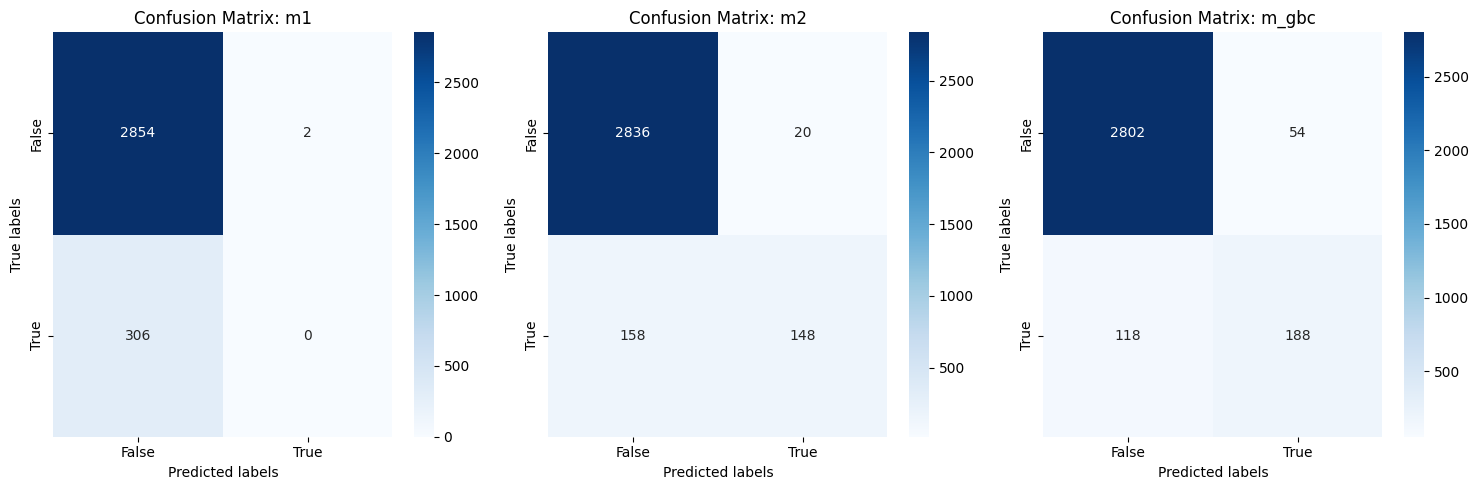

In [112]:
m1_confusion_matrix = confusion_matrix(y_test_data_from_training, y_pred_m1[0])
m2_confusion_matrix = confusion_matrix(y_test_data_from_training, y_pred_m2[0])
m_gbc_confusion_matrix = confusion_matrix(y_test_data_from_training, y_pred_m_gbc[0])


# m1_confusion_matrix = confusion_matrix(y_test, y_pred_m1_full[0])
# m2_confusion_matrix = confusion_matrix(y_test, y_pred_m2_full[0])
# m_gbc_confusion_matrix = confusion_matrix(y_test, y_pred_m_gbc_full[0])


fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

plot_confusion_matrix(m1_confusion_matrix, "m1", ax[0])
plot_confusion_matrix(m2_confusion_matrix, "m2", ax[1])
plot_confusion_matrix(m_gbc_confusion_matrix, "m_gbc", ax[2])


plt.tight_layout()
plt.show()

# Metamorphic Tests

### Create Archetypes

based on the following features:
 - person_sex_woman: 0, 1
 - person_age_during_investigation: 20, 30, 40, 50, 60
 - relationship_child_current_number: 0, 1, 2, 3, 4
 - obstacles_days_financial_problems: min, 2std - mean, std - mean, mean, std + mean, 2std + mean, max
 - relationship_partner_total_days_partner: 0, 2std-mean, std-mean, mean, std+mean, 2std+mean, max

### Archetype1

##### Compose Data

In [113]:
obstacles_days_financial_problems = []
obstacles_days_financial_problems.append(test_data['belemmering_dagen_financiele_problemen'].mean() - 2 * test_data['belemmering_dagen_financiele_problemen'].std())
obstacles_days_financial_problems.append(test_data['belemmering_dagen_financiele_problemen'].mean() - test_data['belemmering_dagen_financiele_problemen'].std())
obstacles_days_financial_problems.append(test_data['belemmering_dagen_financiele_problemen'].mean())
obstacles_days_financial_problems.append(test_data['belemmering_dagen_financiele_problemen'].mean() + 2 * test_data['belemmering_dagen_financiele_problemen'].std())
obstacles_days_financial_problems.append(test_data['belemmering_dagen_financiele_problemen'].mean() + test_data['belemmering_dagen_financiele_problemen'].std())

In [114]:
relationship_partner_total_days_partner = []
relationship_partner_total_days_partner.append(test_data['relatie_partner_totaal_dagen_partner'].mean() - 2 * test_data['relatie_partner_totaal_dagen_partner'].std())
relationship_partner_total_days_partner.append(test_data['relatie_partner_totaal_dagen_partner'].mean() - test_data['relatie_partner_totaal_dagen_partner'].std())
relationship_partner_total_days_partner.append(test_data['relatie_partner_totaal_dagen_partner'].mean())
relationship_partner_total_days_partner.append(test_data['relatie_partner_totaal_dagen_partner'].mean() + 2 * test_data['relatie_partner_totaal_dagen_partner'].std())
relationship_partner_total_days_partner.append(test_data['relatie_partner_totaal_dagen_partner'].mean() + test_data['relatie_partner_totaal_dagen_partner'].std())

In [115]:
person_sex_woman = [0, 1]
person_age_during_investigation = [20, 30, 40, 50, 60]
relationship_child_current_number = [0, 1, 2, 3, 4]

In [116]:
archetype_test = list(product(person_sex_woman, person_age_during_investigation, relationship_child_current_number, relationship_partner_total_days_partner, obstacles_days_financial_problems))
archetype_test = pd.DataFrame(archetype_test, columns=['persoon_geslacht_vrouw', 'persoon_leeftijd', 'relatie_kind_huidige_aantal', 'relatie_partner_totaal_dagen_partner', 'belemmering_dagen_financiele_problemen'])

In [117]:
mean_df = pd.DataFrame([X_test.mean()])
mean_df.drop(columns=['persoon_geslacht_vrouw', 'persoon_leeftijd_bij_onderzoek', 'relatie_kind_huidige_aantal', 'relatie_partner_totaal_dagen_partner', 'belemmering_dagen_financiele_problemen'], inplace=True)
mean_df

,adres_aantal_brp_adres,adres_aantal_verschillende_wijken,adres_aantal_verzendadres,adres_aantal_woonadres_handmatig,adres_dagen_op_adres,adres_recentst_onderdeel_rdam,adres_recentste_buurt_groot_ijsselmonde,adres_recentste_buurt_nieuwe_westen,adres_recentste_buurt_other,adres_recentste_buurt_oude_noorden,...,typering_dagen_som,typering_hist_aantal,typering_hist_inburgeringsbehoeftig,typering_hist_ind,typering_hist_sector_zorg,typering_ind,typering_indicatie_geheime_gegevens,typering_other,typering_transport__logistiek___tuinbouw,typering_zorg__schoonmaak___welzijn
0,2.878529,2.101621,0.433294,0.494346,9904.946289,0.950415,0.003638,0.002293,0.499644,0.00087,...,2175.716553,1.673468,0.006801,1.0,0.01036,0.681297,0.065164,0.422301,0.016291,0.006801


In [118]:
archetype_test_data = pd.merge(mean_df, archetype_test, how='cross')
archetype_test_data

,adres_aantal_brp_adres,adres_aantal_verschillende_wijken,adres_aantal_verzendadres,adres_aantal_woonadres_handmatig,adres_dagen_op_adres,adres_recentst_onderdeel_rdam,adres_recentste_buurt_groot_ijsselmonde,adres_recentste_buurt_nieuwe_westen,adres_recentste_buurt_other,adres_recentste_buurt_oude_noorden,...,typering_ind,typering_indicatie_geheime_gegevens,typering_other,typering_transport__logistiek___tuinbouw,typering_zorg__schoonmaak___welzijn,persoon_geslacht_vrouw,persoon_leeftijd,relatie_kind_huidige_aantal,relatie_partner_totaal_dagen_partner,belemmering_dagen_financiele_problemen
0,2.878529,2.101621,0.433294,0.494346,9904.946289,0.950415,0.003638,0.002293,0.499644,0.00087,...,0.681297,0.065164,0.422301,0.016291,0.006801,0,20,0,-812.911974,-5602.473834
1,2.878529,2.101621,0.433294,0.494346,9904.946289,0.950415,0.003638,0.002293,0.499644,0.00087,...,0.681297,0.065164,0.422301,0.016291,0.006801,0,20,0,-812.911974,-2603.406272
2,2.878529,2.101621,0.433294,0.494346,9904.946289,0.950415,0.003638,0.002293,0.499644,0.00087,...,0.681297,0.065164,0.422301,0.016291,0.006801,0,20,0,-812.911974,395.661290
3,2.878529,2.101621,0.433294,0.494346,9904.946289,0.950415,0.003638,0.002293,0.499644,0.00087,...,0.681297,0.065164,0.422301,0.016291,0.006801,0,20,0,-812.911974,6393.796414
4,2.878529,2.101621,0.433294,0.494346,9904.946289,0.950415,0.003638,0.002293,0.499644,0.00087,...,0.681297,0.065164,0.422301,0.016291,0.006801,0,20,0,-812.911974,3394.728852
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1245,2.878529,2.101621,0.433294,0.494346,9904.946289,0.950415,0.003638,0.002293,0.499644,0.00087,...,0.681297,0.065164,0.422301,0.016291,0.006801,1,60,4,2824.348776,-5602.473834
1246,2.878529,2.101621,0.433294,0.494346,9904.946289,0.950415,0.003638,0.002293,0.499644,0.00087,...,0.681297,0.065164,0.422301,0.016291,0.006801,1,60,4,2824.348776,-2603.406272
1247,2.878529,2.101621,0.433294,0.494346,9904.946289,0.950415,0.003638,0.002293,0.499644,0.00087,...,0.681297,0.065164,0.422301,0.016291,0.006801,1,60,4,2824.348776,395.661290
1248,2.878529,2.101621,0.433294,0.494346,9904.946289,0.950415,0.003638,0.002293,0.499644,0.00087,...,0.681297,0.065164,0.422301,0.016291,0.006801,1,60,4,2824.348776,6393.796414


#### Test on different models

In [119]:
y_archetype_test_zeros = pd.DataFrame(np.zeros(1250), columns=['checked'])
X_archetype_test_zeros = archetype_test_data.copy(deep=True).astype(np.float32)

y_archetype_test_ones = pd.DataFrame(np.ones(1250), columns=['checked'])
X_archetype_test_ones = archetype_test_data.copy(deep=True).astype(np.float32)

y_archetype_test_random = pd.DataFrame(np.random.randint(2,size=1250), columns=['checked'])
X_archetype_test_random = archetype_test_data.copy(deep=True).astype(np.float32)

In [120]:
y_pred_m1_zeros =  model_1.run(None, {'X': X_archetype_test_zeros.values.astype(np.float32)})
y_pred_m1_ones =  model_1.run(None, {'X': X_archetype_test_ones.values.astype(np.float32)})
y_pred_m1_random =  model_1.run(None, {'X': X_archetype_test_random.values.astype(np.float32)})

evaluate_m1_zeros = evaluate(y_archetype_test_zeros, y_pred_m1_zeros[0])
evaluate_m1_ones = evaluate(y_archetype_test_ones, y_pred_m1_ones[0])
evaluate_m1_random = evaluate(y_archetype_test_random, y_pred_m1_random[0])
print('Evaluation of m1 on test zeros: ', evaluate_m1_zeros)
print('Evaluation of m1 on test ones: ', evaluate_m1_ones)
print('Evaluation of m1 on test random: ', evaluate_m1_random)

Evaluation of m1 on test zeros:  (1.0, 0.0, 0.0, 0.0)
Evaluation of m1 on test ones:  (0.0, 0.0, 0.0, 0.0)
Evaluation of m1 on test random:  (0.4872, 0.0, 0.0, 0.0)


In [121]:
y_pred_m2_zeros =  model_2.run(None, {'X': X_archetype_test_zeros.values.astype(np.float32)})
y_pred_m2_ones =  model_2.run(None, {'X': X_archetype_test_ones.values.astype(np.float32)})
y_pred_m2_random =  model_2.run(None, {'X': X_archetype_test_random.values.astype(np.float32)})

evaluate_m2_zeros = evaluate(y_archetype_test_zeros, y_pred_m2_zeros[0])
evaluate_m2_ones = evaluate(y_archetype_test_ones, y_pred_m2_ones[0])
evaluate_m2_random = evaluate(y_archetype_test_random, y_pred_m2_random[0])
print('Evaluation of m2 on test: ', evaluate_m2_zeros)
print('Evaluation of m2 on test: ', evaluate_m2_ones)
print('Evaluation of m2 on test: ', evaluate_m2_random)

Evaluation of m2 on test:  (0.6, 0.0, 0.0, 0.0)
Evaluation of m2 on test:  (0.4, 1.0, 0.4, 0.5714285714285715)
Evaluation of m2 on test:  (0.4856, 0.498, 0.38845553822152884, 0.43645924627519717)


In [122]:
y_pred_m_gbc_zeros =  model_gbc.run(None, {'X': X_archetype_test_zeros.values.astype(np.float32)})
y_pred_m_gbc_ones =  model_gbc.run(None, {'X': X_archetype_test_ones.values.astype(np.float32)})
y_pred_m_gbc_random =  model_gbc.run(None, {'X': X_archetype_test_random.values.astype(np.float32)})

evaluate_m_gbc_zeros = evaluate(y_archetype_test_zeros, y_pred_m_gbc_zeros[0])
evaluate_m_gbc_ones = evaluate(y_archetype_test_ones, y_pred_m_gbc_ones[0])
evaluate_m_gbc_random = evaluate(y_archetype_test_random, y_pred_m_gbc_random[0])
print('Evaluation of m_gbc on test: ', evaluate_m_gbc_zeros)
print('Evaluation of m_gbc on test: ', evaluate_m_gbc_ones)
print('Evaluation of m_gbc on test: ', evaluate_m_gbc_random)

Evaluation of m_gbc on test:  (0.0, 0.0, 0.0, 0.0)
Evaluation of m_gbc on test:  (1.0, 1.0, 1.0, 1.0)
Evaluation of m_gbc on test:  (0.5128, 0.5128, 1.0, 0.6779481755684824)


In [123]:
print(len([x for x in y_pred_m1_ones[0] if x == 0]))
print(len([x for x in y_pred_m1_ones[0] if x == 1]))
print()
print(len([x for x in y_pred_m2_ones[0] if x == 0]))
print(len([x for x in y_pred_m2_ones[0] if x == 1]))
print()
print(len([x for x in y_pred_m_gbc_ones[0] if x == 0]))
print(len([x for x in y_pred_m_gbc_ones[0] if x == 1]))

1250
0

750
500

0
1250


#### Confusion Matrix

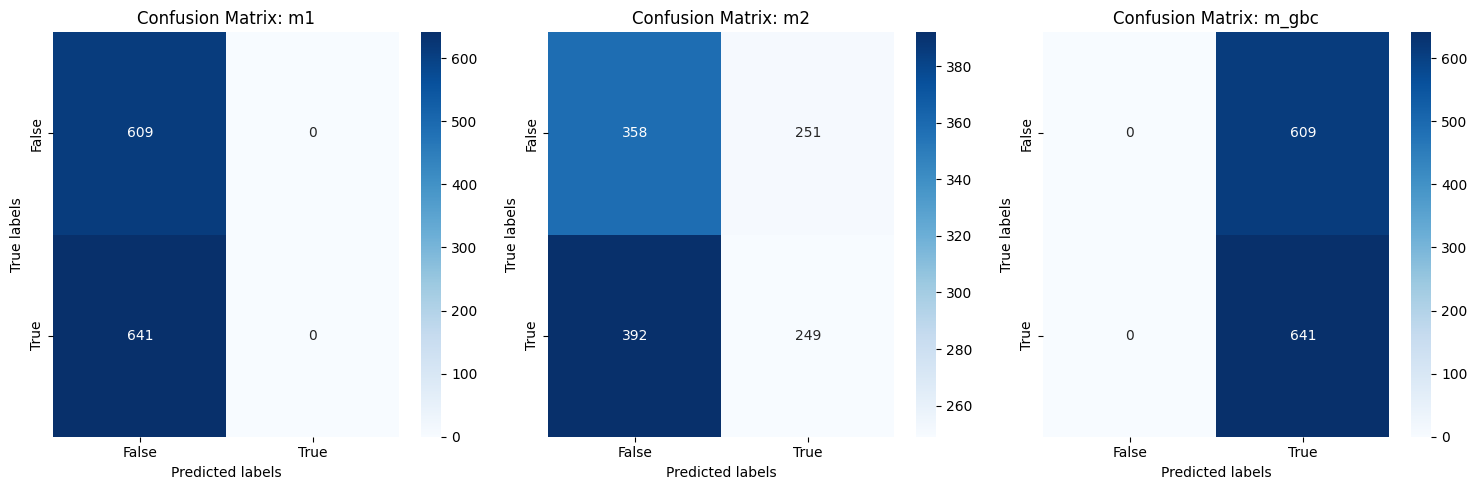

In [189]:
m1_confusion_matrix_zeros = confusion_matrix(y_archetype_test_zeros, y_pred_m1_zeros[0])
m2_confusion_matrix_zeros = confusion_matrix(y_archetype_test_zeros, y_pred_m2_zeros[0])
m_gbc_confusion_matrix_zeros = confusion_matrix(y_archetype_test_zeros, y_pred_m_gbc_zeros[0])
m1_confusion_matrix_ones = confusion_matrix(y_archetype_test_ones, y_pred_m1_ones[0])
m2_confusion_matrix_ones = confusion_matrix(y_archetype_test_ones, y_pred_m2_ones[0])
m_gbc_confusion_matrix_ones = confusion_matrix(y_archetype_test_ones, y_pred_m_gbc_ones[0])
m1_confusion_matrix_random = confusion_matrix(y_archetype_test_random, y_pred_m1_random[0])
m2_confusion_matrix_random = confusion_matrix(y_archetype_test_random, y_pred_m2_random[0])
m_gbc_confusion_matrix_random = confusion_matrix(y_archetype_test_random, y_pred_m_gbc_random[0])

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
plot_confusion_matrix(m1_confusion_matrix_random, "m1", ax[0])
plot_confusion_matrix(m2_confusion_matrix_random, "m2", ax[1])
plot_confusion_matrix(m_gbc_confusion_matrix_random, "m_gbc", ax[2])

# plot_confusion_matrix(m1_confusion_matrix_ones, "m1", ax[0])
# plot_confusion_matrix(m2_confusion_matrix_ones, "m2", ax[1])
# plot_confusion_matrix(m_gbc_confusion_matrix_ones, "m_gbc", ax[2])

# plot_confusion_matrix(m1_confusion_matrix_zeros, "m1", ax[0])
# plot_confusion_matrix(m2_confusion_matrix_zeros, "m2", ax[1])
# plot_confusion_matrix(m_gbc_confusion_matrix_zeros, "m_gbc", ax[2])


plt.tight_layout()
plt.show()

### Fixed Categorical

In [183]:
def metamorphic_testing_fixed_categorical(model, input, targets, feature, model_name):

  if feature not in input.columns:
    raise ValueError(f"The feature '{feature}' is not found in the data.")

  results = []

  values = input[feature].unique()
  for value in values:
    test_data = input.copy(deep=True)
    test_data[feature] = value
    predictions = model.run(None, {'X': test_data.values.astype(np.float32)})
    evaluation = evaluate(targets, predictions[0])
    results.append({'Feature': feature,
                    'model': model_name,
                    'Value': value,
                    'accuracy': evaluation[0],
                    'precision': evaluation[1],
                    'recall': evaluation[2],
                    'f1': evaluation[3]})
  return pd.DataFrame(results)

In [184]:
features = ['relatie_kind_heeft_kinderen', 'persoon_geslacht_vrouw', 'relatie_kind_huidige_aantal']
fixed_categorical_values_test_results = []

for ft in features:
  fixed_categorical_values_test_results.append(metamorphic_testing_fixed_categorical(model_1, X_test_data_from_training, y_test_data_from_training, ft, "model_1"))
  fixed_categorical_values_test_results.append(metamorphic_testing_fixed_categorical(model_2, X_test_data_from_training, y_test_data_from_training, ft, "model_2"))
  fixed_categorical_values_test_results.append(metamorphic_testing_fixed_categorical(model_gbc, X_test_data_from_training, y_test_data_from_training, ft, "model_gbc"))

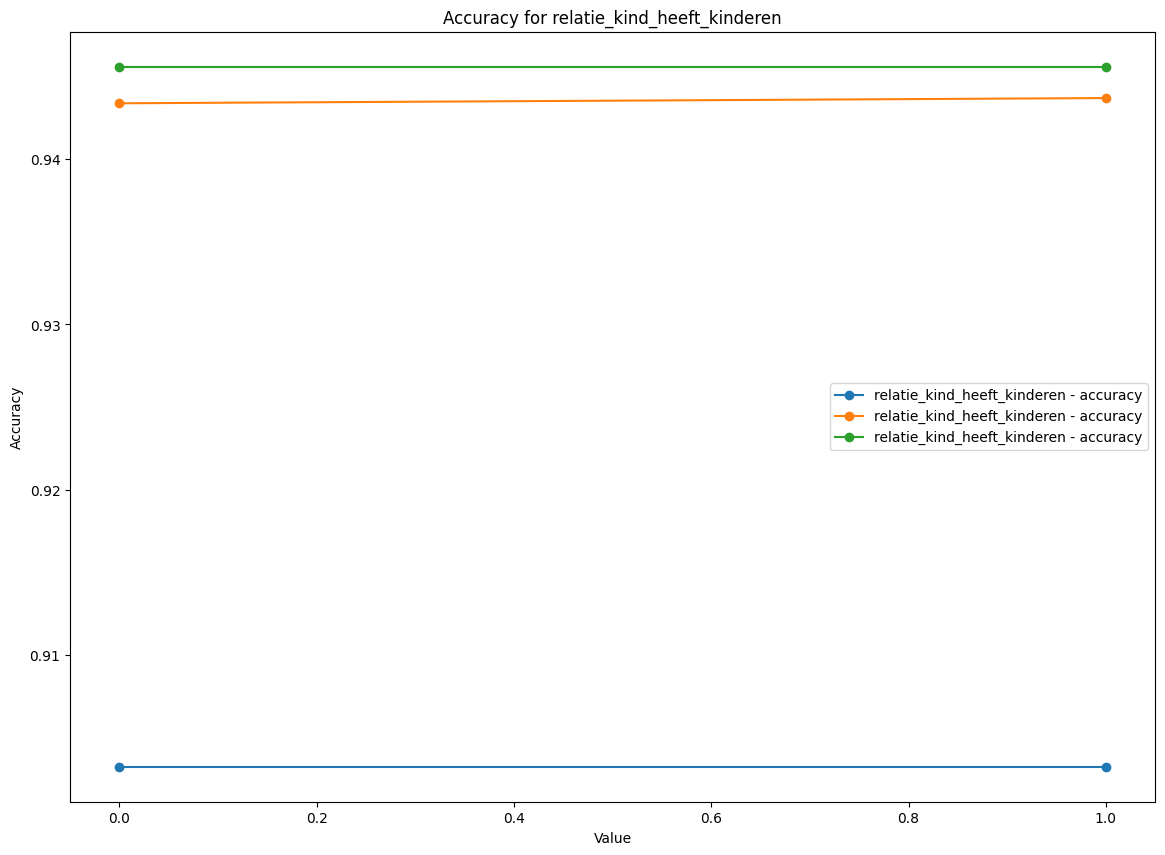

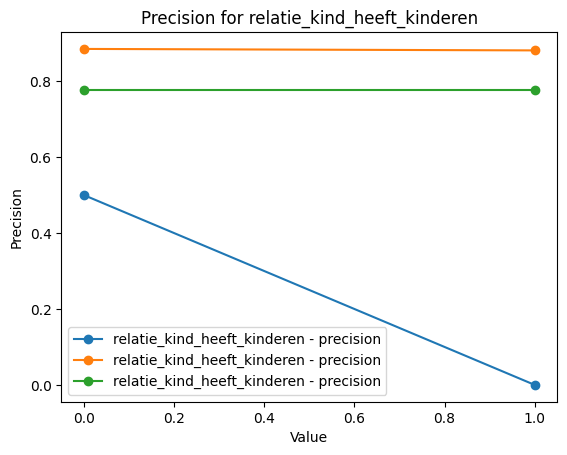

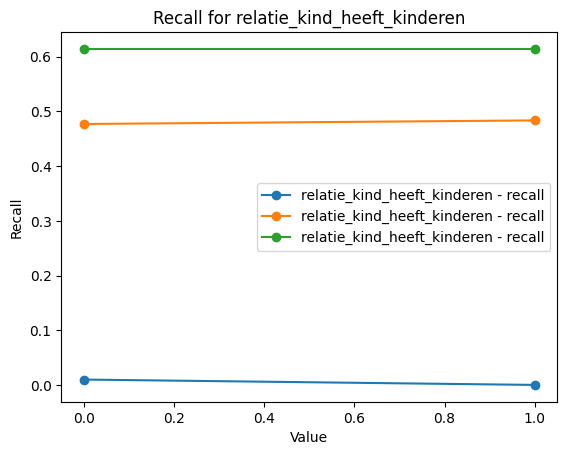

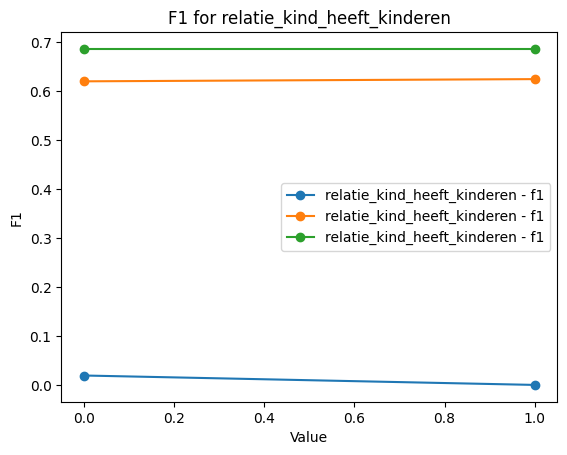

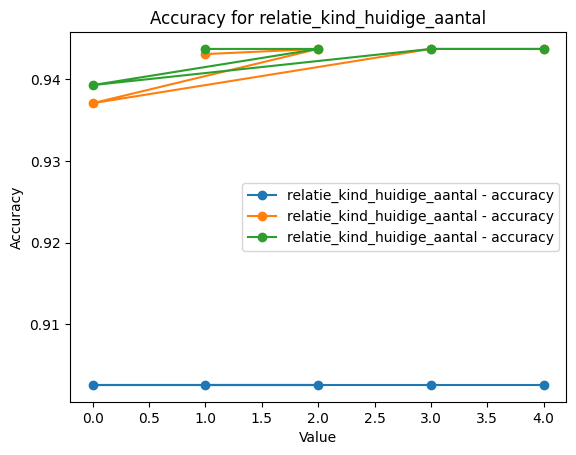

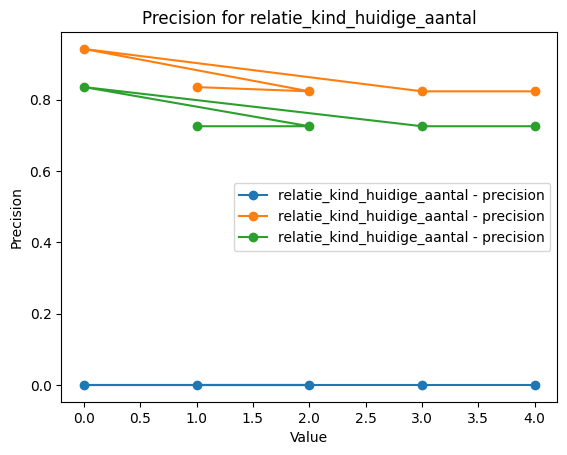

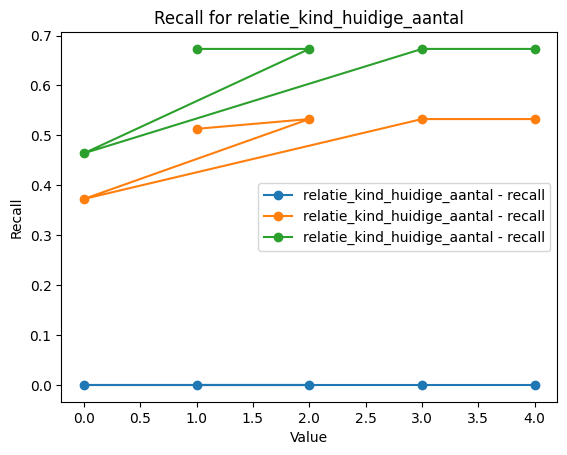

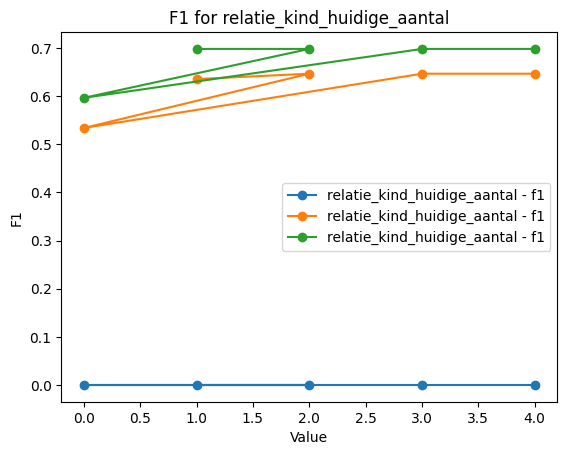

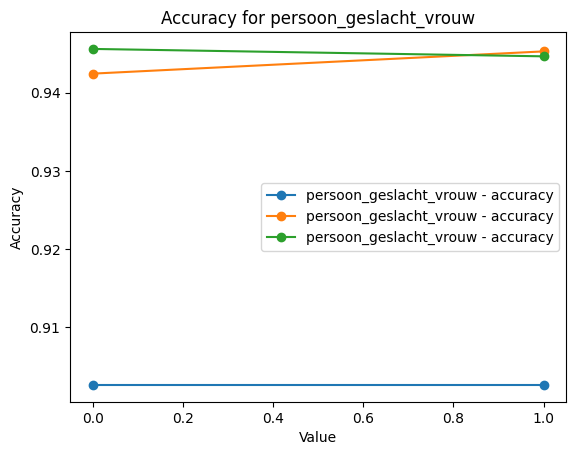

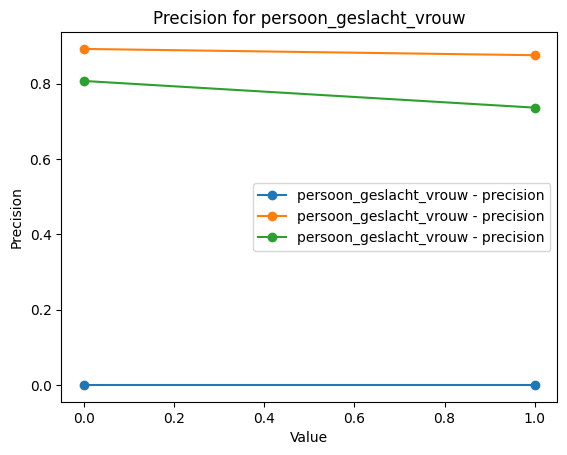

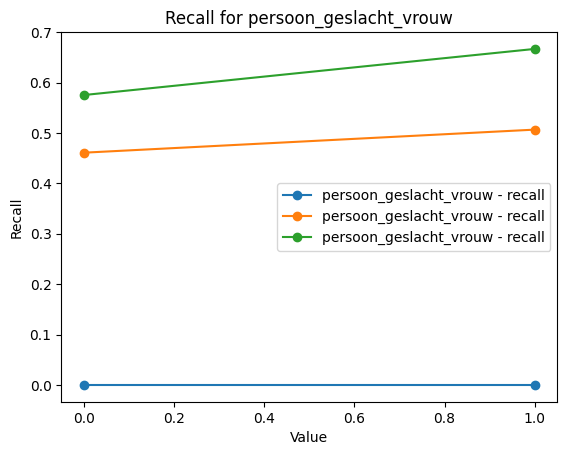

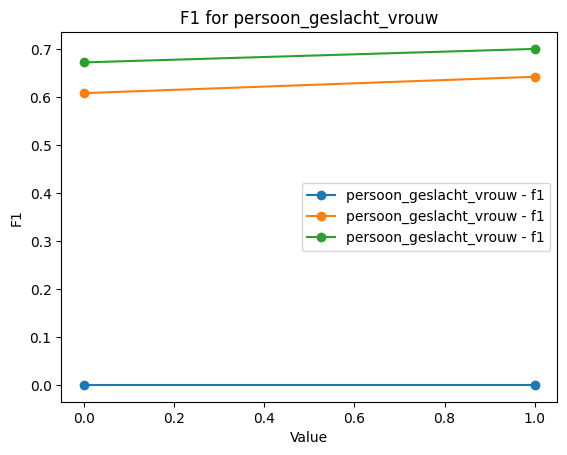

In [186]:
def plot_evaluation_metrics(data):
  plt.figure(figsize=(14, 10))
  features = set()

  for df in data:
    for f in df['Feature'].unique():
      features.add(f)

  metrics = ['accuracy', 'precision', 'recall', 'f1']

  for feature in features:
    for metric in metrics:
      plt.clf()
      for df in data:
        feature_df = df[df['Feature'] == feature]
        if not feature_df.empty:
            plt.plot(feature_df['Value'], feature_df[metric], marker='o', label=f'{feature} - {metric}')
      plt.title(f'{metric.capitalize()} for {feature}')
      plt.xlabel('Value')
      plt.ylabel(metric.capitalize())
      plt.legend()
      plt.show()

plot_evaluation_metrics(fixed_categorical_values_test_results)

### Constant Noise

In [182]:
def metamorphic_testing_constant_noise(model, data, feature, noise_value):

  if feature not in data.columns:
    raise ValueError(f"The feature '{feature}' is not found in the data.")

  results = []
  noisy_values = []
  for val in data[feature]:
    noisy_values.append(val + noise_value)

  test_data = data.copy(deep=True)
  test_data[feature] = noisy_values
  print(test_data[feature])
  predictions = model.run(None, {'X': test_data.values.astype(np.float32)})
  evaluation = evaluate(y_test, predictions)

  results.append({'Feature': feature,
                  'accuracy': evaluation[0],
                  'precision': evaluation[1],
                  'recall': evaluation[2],
                  'f1': evaluation[3]})

  return pd.DataFrame(results)


features = ['', '', '', '']
constant_noise_test_results = []


for ft in features:
  constant_noise_test_results.append(metamorphic_testing_constant_noise(model_1, X_test_data_from_training, y_test_data_from_training, ft, "model_1"))
  constant_noise_test_results.append(metamorphic_testing_constant_noise(model_2, X_test_data_from_training, y_test_data_from_training, ft, "model_2"))
  constant_noise_test_results.append(metamorphic_testing_constant_noise(model_gbc, X_test_data_from_training, y_test_data_from_training, ft, "model_gbc"))

# Values Distribution

In [ ]:
critical_features = ['persoon_geslacht_vrouw',
                     'persoon_leeftijd_bij_onderzoek',
                     'relatie_kind_huidige_aantal',
                     'relatie_partner_totaal_dagen_partner',
                     'belemmering_dagen_financiele_problemen'
                    ]

features_to_plot = critical_features + list(og_data.columns.difference(critical_features))

n_features = len(features_to_plot)
n_cols = 3
n_rows = (n_features + n_cols - 1) // n_cols

plt.figure(figsize=(24, 4 * n_rows))

for i, feature in enumerate(features_to_plot, 1):
  plt.subplot(n_rows, n_cols, i)
  sns.histplot(og_data[feature], kde=True, bins=20)
  plt.title(feature)

plt.tight_layout()
plt.show()

### Values Distribution per calssification result